In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import norm, skew #for some statistics
from scipy import stats
pd.set_option('display.max_row', None)
pd.set_option('display.max_column', None)

In [2]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')
print('[*]train.shape : {}'.format(train.shape))
print('[*]test.shape  : {}'.format(test.shape))

[*]train.shape : (1460, 81)
[*]test.shape  : (1459, 80)


In [7]:
train.head(30)['MSSubClass']+90


0     150
1     110
2     150
3     160
4     150
5     140
6     110
7     150
8     140
9     280
10    110
11    150
12    110
13    110
14    110
15    135
16    110
17    180
18    110
19    110
20    150
21    135
22    110
23    210
24    110
25    110
26    110
27    110
28    110
29    120
Name: MSSubClass, dtype: int64

# Compare train & test dataset

In [7]:
def compare_train_test(colname, graph='count'):
    figsize=(10,3)
    if graph=='count':
        fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        fig.suptitle('{} of {}'.format(graph, colname))
        axarr[0].title.set_text('train data')
        sns.countplot(x=train[colname], data=train, ax=axarr[0])
        axarr[1].title.set_text('test data')
        sns.countplot(x=train[colname], data=test,  ax=axarr[1])
    elif graph=='kde':
        fig = plt.figure(figsize=figsize)
        fig.suptitle('{} of {}'.format(graph, colname))
        sns.kdeplot(train[colname], label='train')
        sns.kdeplot(test[colname], label='test')

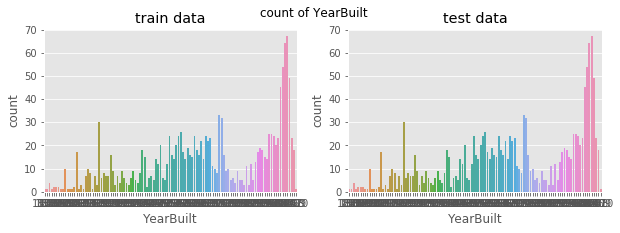

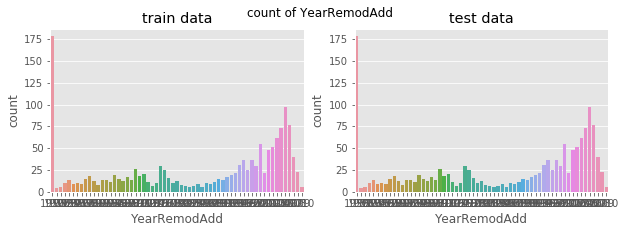

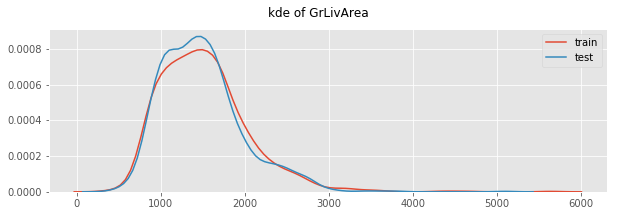

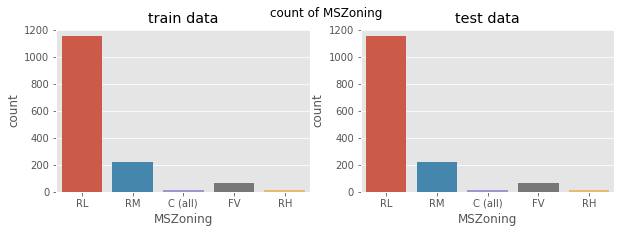

In [8]:
compare_train_test('YearBuilt')
compare_train_test('YearRemodAdd')
compare_train_test('GrLivArea', graph='kde')
compare_train_test('MSZoning')

train data와 test data는 상당히 유사한 데이터 분포를 보인다고 할 수 있다.

train data의 feature간 특성을 완벽히 이해하는 것이 가장 중요하다.

# Feature Analysis

np.log1p <-> np.expm1

## SalePrice

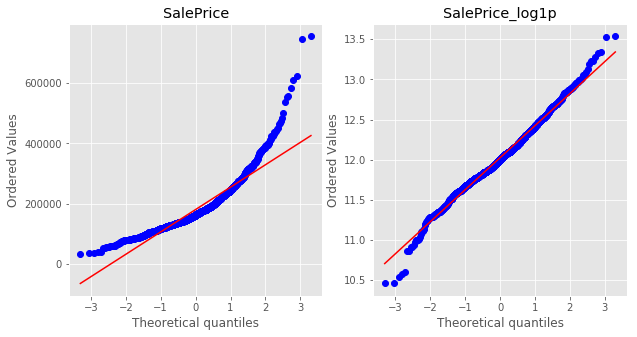

In [9]:
def plot_SalePrice(train):
    train = train.copy()
    #Get also the QQ-plot
    fig = plt.figure(figsize=(10,5))
    ax1 = plt.subplot(121)
    stats.probplot(train['SalePrice'], plot=plt)
    ax1.set_title('SalePrice')
    ax2 = plt.subplot(122)
    stats.probplot(np.log1p(train["SalePrice"]), plot=plt)
    ax2.set_title('SalePrice_log1p')
    plt.show()
plot_SalePrice(train)

In [10]:
def add_saleprice_log(train):
    train = train.copy()
    train['SalePrice_log'] = np.log(train['SalePrice'])
    
    return train

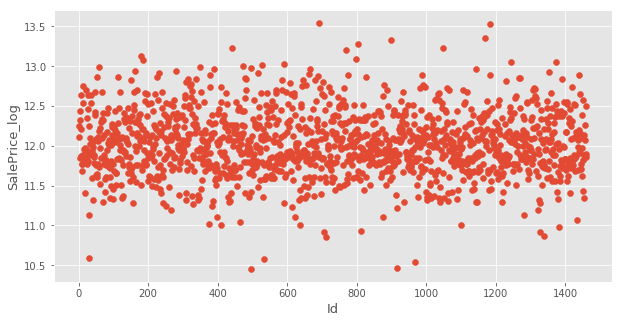

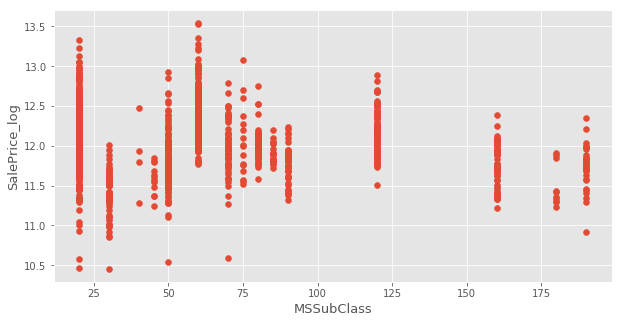

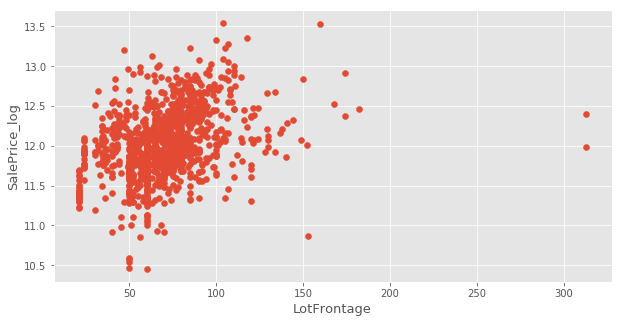

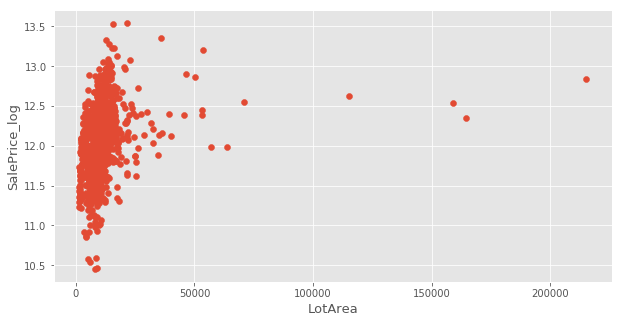

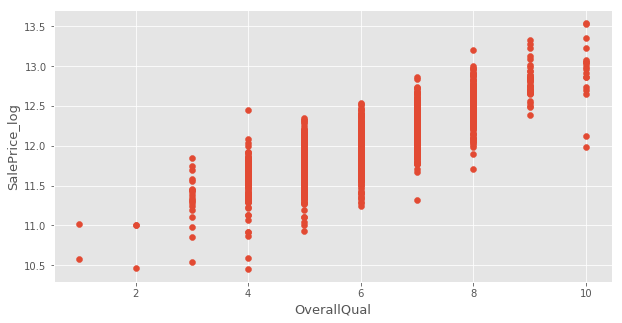

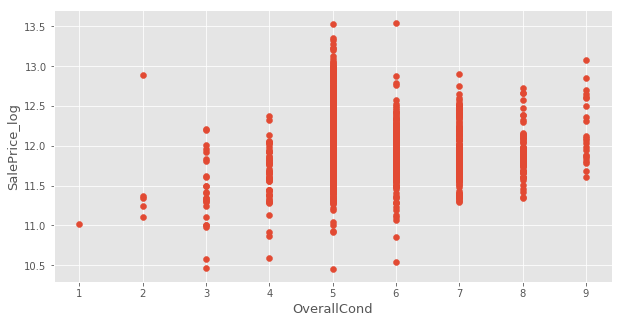

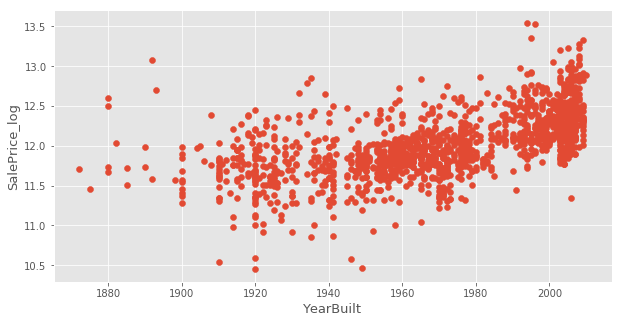

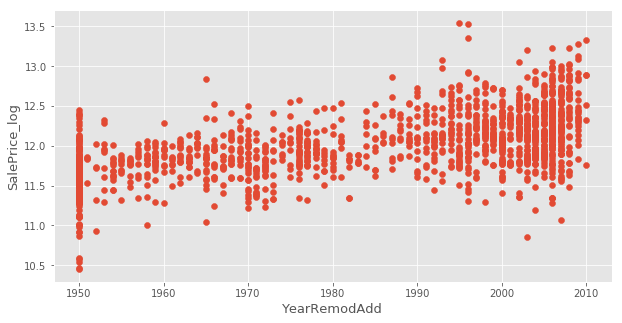

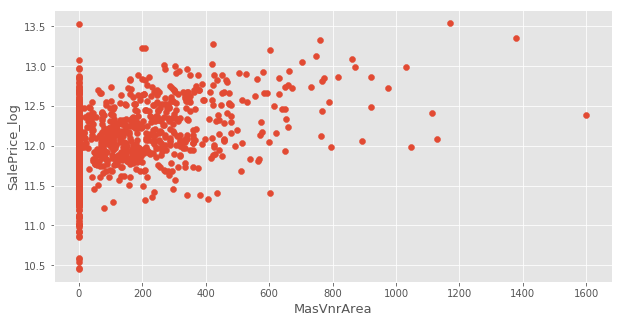

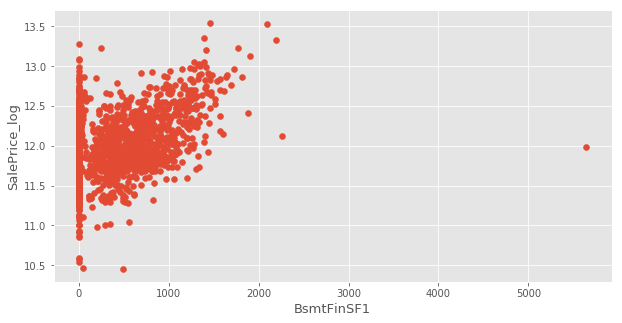

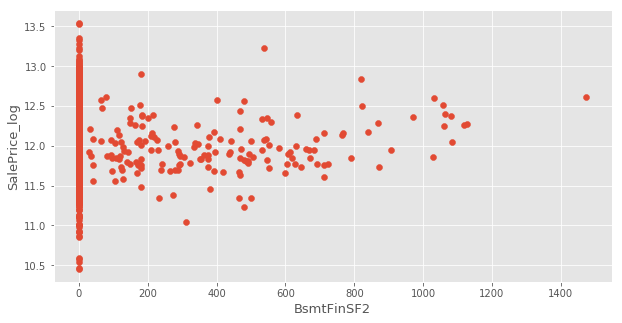

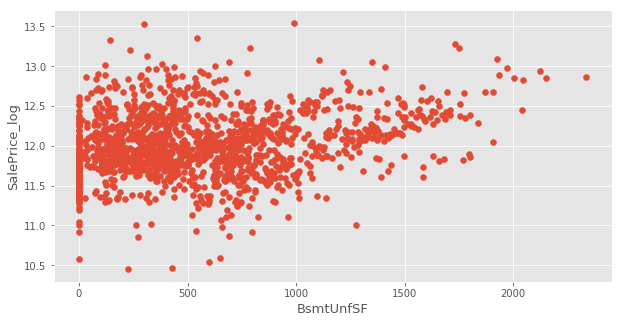

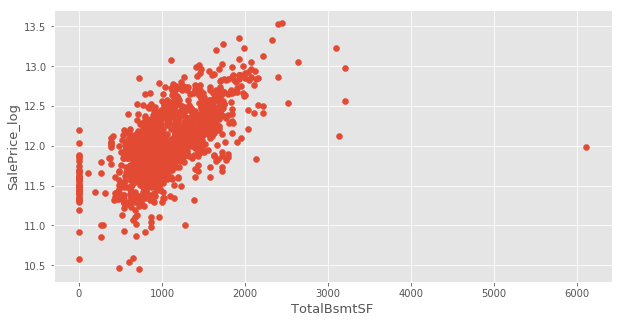

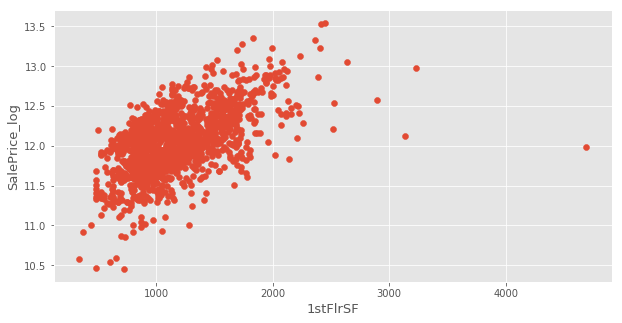

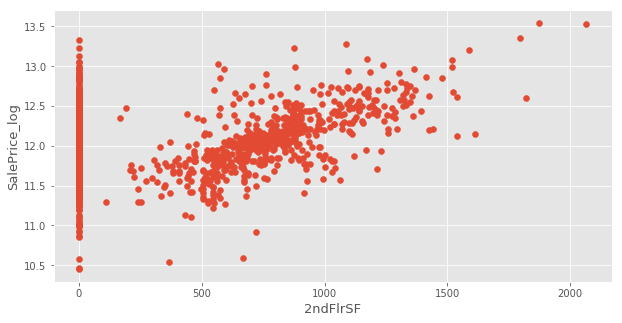

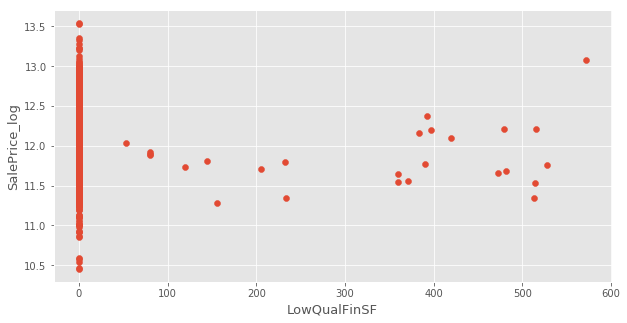

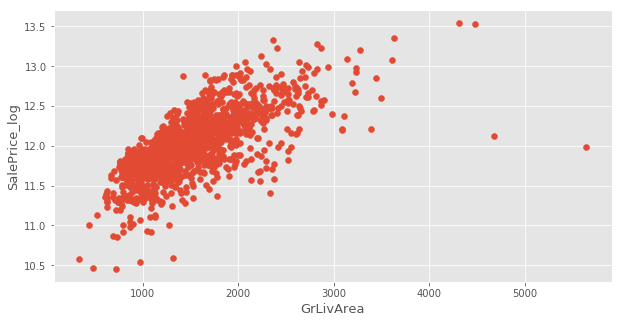

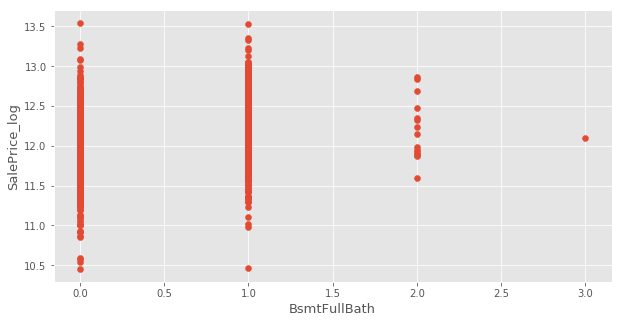

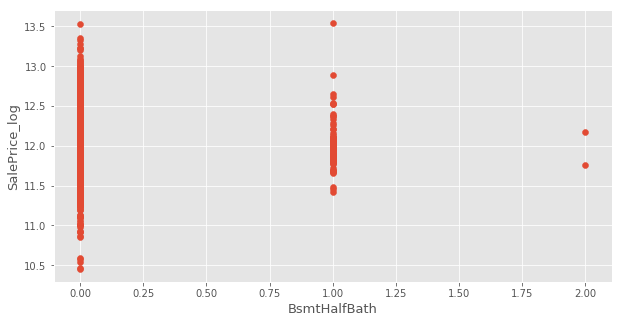

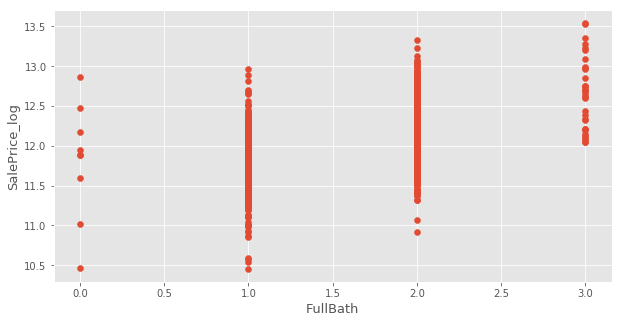

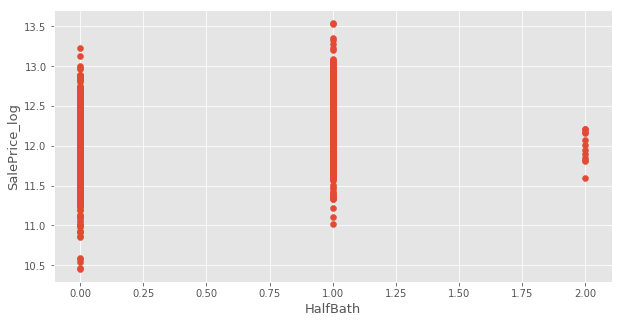

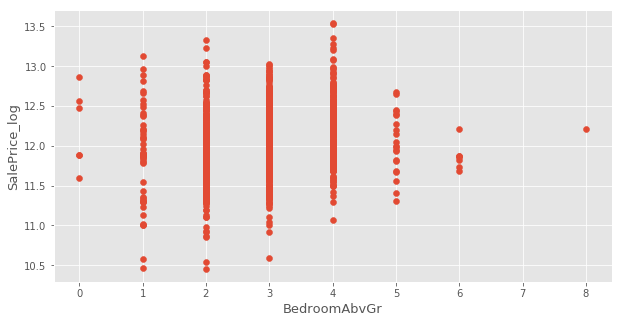

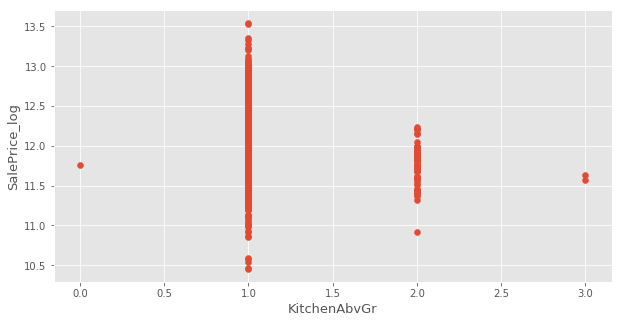

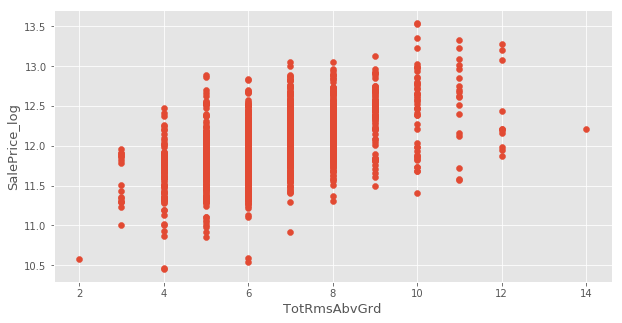

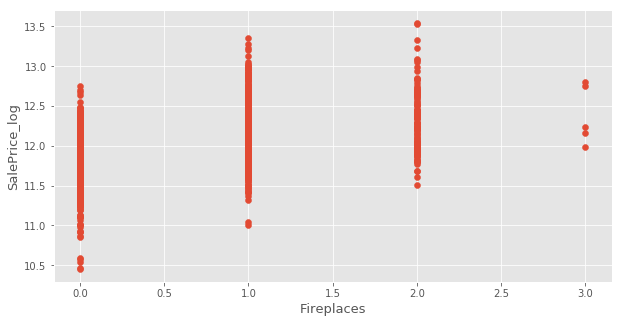

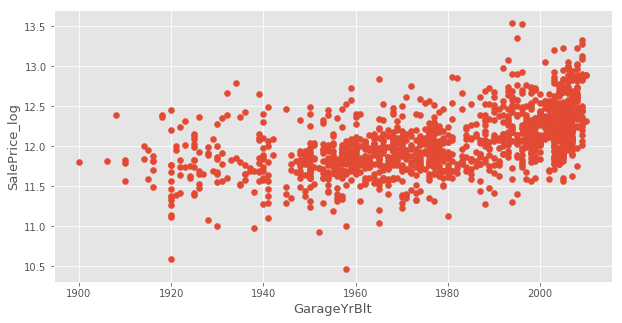

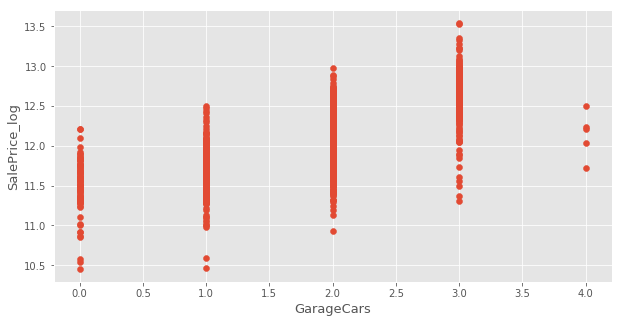

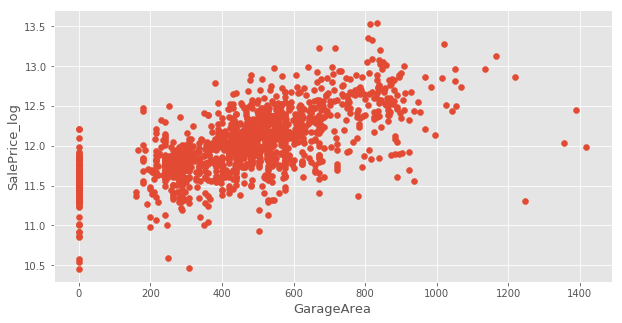

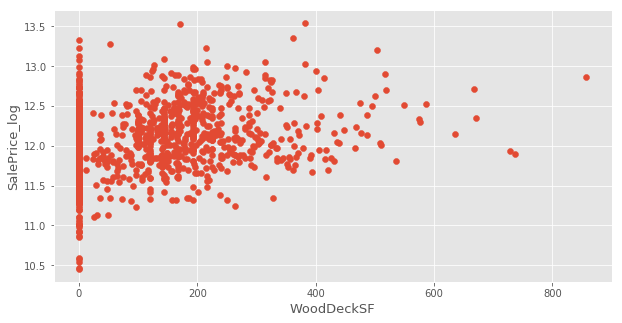

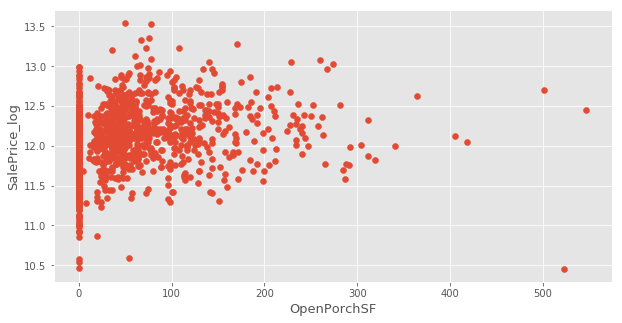

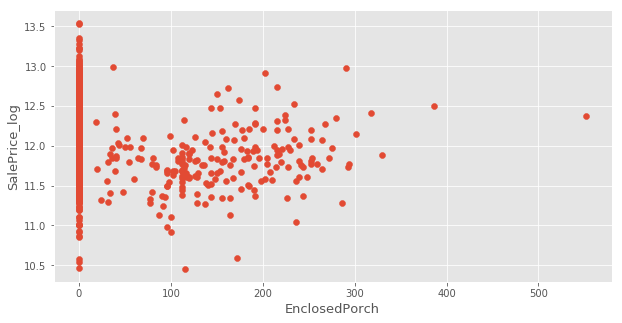

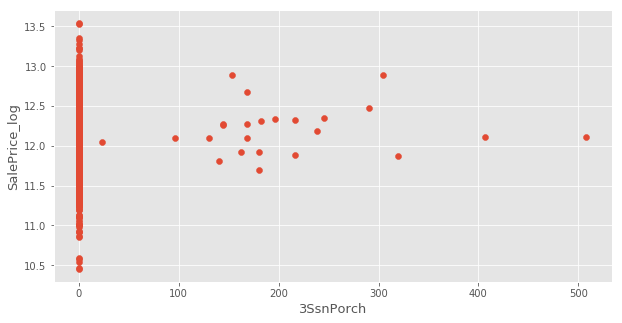

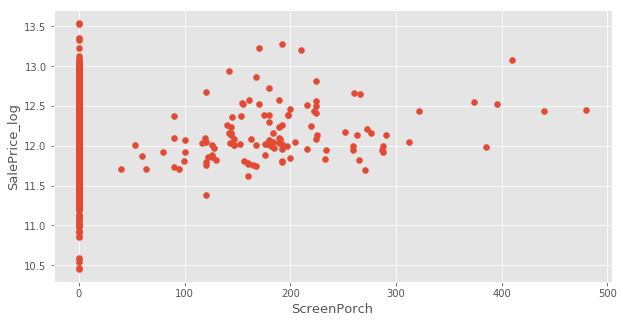

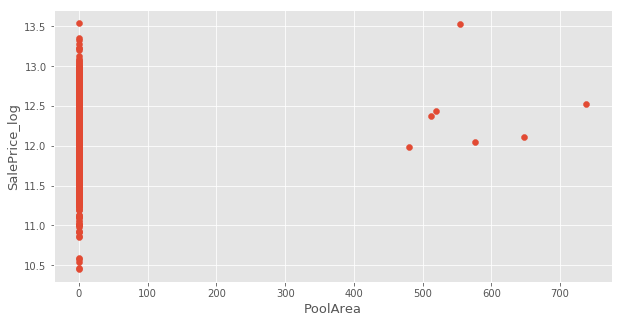

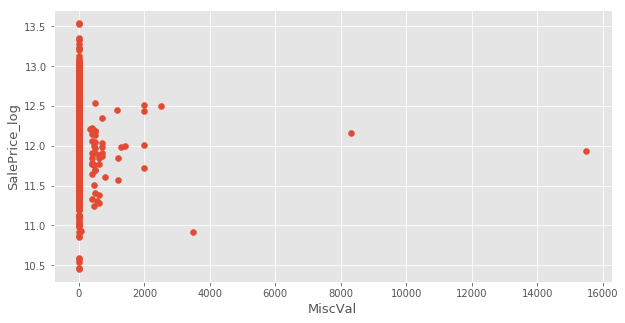

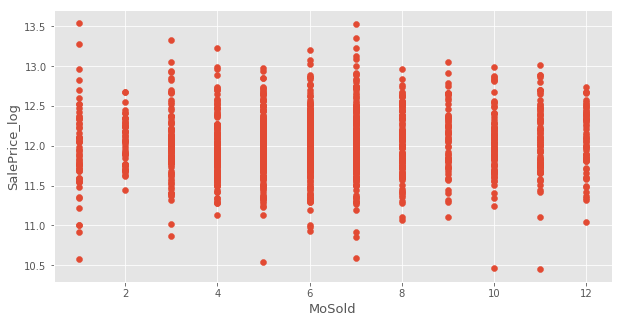

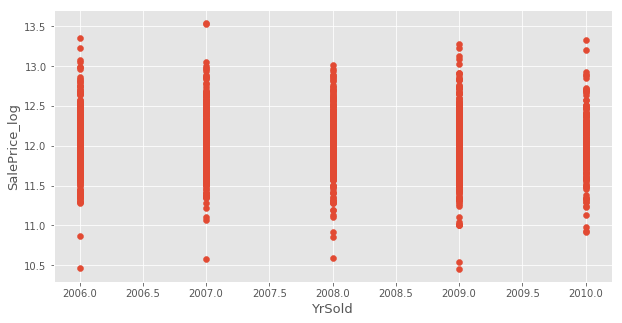

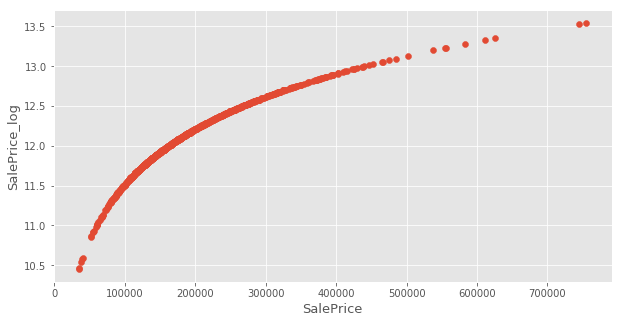

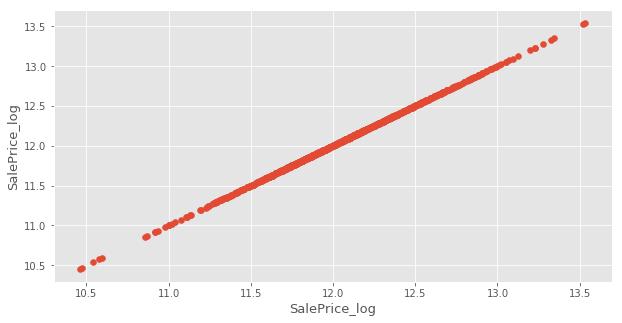

In [11]:
def find_outliers(train):
    train  = train.copy()
    target = 'SalePrice_log'
    X_numeric=train.select_dtypes(exclude=["object"])
    for col in X_numeric:
        fig, ax = plt.subplots(figsize=(10,5))
        ax.scatter(x = train[col], y = train[target])
        plt.ylabel(target, fontsize=13)
        plt.xlabel(col, fontsize=13)
        plt.show()
find_outliers(add_saleprice_log(train))

In [12]:
def remove_outliers(train):
    train = train.copy()
    #outliers = [30, 88, 462, 631, 1322]
    #train = train.drop(train.index[outliers])
    
    target = train[(train["GrLivArea"]>4000) & (train["SalePrice_log"]<12.5)]
    train.drop(target.index,inplace=True)
    '''
    target = train[(train["GarageArea"]>1200) & (train["SalePrice_log"]<11.5)]
    train.drop(target.index,inplace=True)
    
    target = train[(train["LotFrontage"]>150)&(train["SalePrice_log"]<11)]
    train.drop(target.index, inplace=True)
    target = train[(train["OverallQual"]==10) & (train["SalePrice_log"]<12.5)]
    train.drop(target.index,inplace=True)
    target = train[(train["OpenPorchSF"]>500) & (train["SalePrice_log"]<11)]
    train.drop(target.index,inplace=True)
    target = train[(train['BsmtFinSF1']>5000)]
    train.drop(target.index, inplace=True)
    target = train[(train['BsmtFinSF2']>1400)]
    train.drop(target.index, inplace=True)
    target = train[(train['TotalBsmtSF']>6000)]
    train.drop(target.index, inplace=True)
    target = train[(train['1stFlrSF']>4000)]
    train.drop(target.index, inplace=True)
    '''
    return train


In [13]:
def fix_anormaly(df):
    df = df.copy()
    
    
    df['LotFrontage'] = df['LotFrontage'].apply(lambda x:200 if x>300 else x)
    df['LotArea'] = df['LotArea'].apply(lambda x:70000 if x>100000 else x)
    df['BsmtFinSF1'] = df['BsmtFinSF1'].apply(lambda x:2000 if x>6000 else x)
    df['BsmtFinSF2'] = df['BsmtFinSF2'].apply(lambda x:1200 if x>1400 else x)
    df['1stFlrSF'] = df['1stFlrSF'].apply(lambda x:3500 if x>4000 else x)
    df['TotalBsmtSF'] = df['TotalBsmtSF'].apply(lambda x:3500 if x>6000 else x)
    
    df['BsmtFullBath'] = df['BsmtFullBath'].apply(lambda x:2.0 if x>2.0 else x)
    df['BsmtHalfBath'] = df['BsmtHalfBath'].apply(lambda x:1.0 if x>1.0 else x)
    df['HalfBath'] = df['HalfBath'].apply(lambda x:1.0 if x>1.0 else x)
    df['TotRmsAbvGrd'] = df['TotRmsAbvGrd'].apply(lambda x:11 if x>11 else x)
    df['Fireplaces'] = df['Fireplaces'].apply(lambda x:2 if x>2 else x)
    df['GarageCars'] = df['GarageCars'].apply(lambda x:3.0 if x>3.0 else x)
    
    return df


In [14]:
def fill_manualy(df):
    df = df.copy()
    
    #PoolQC
    df.loc[2418, 'PoolQC'] = 'Fa'
    df.loc[2501, 'PoolQC'] = 'Gd'
    df.loc[2597, 'PoolQC'] = 'Fa'
    df['PoolQC'] = df['PoolQC'].fillna("None")
    df.loc[2124, 'GarageYrBlt'] = df['GarageYrBlt'].median()
    df.loc[2574, 'GarageYrBlt'] = df['GarageYrBlt'].median()

    df.loc[2124, 'GarageFinish'] = df['GarageFinish'].mode()[0]
    df.loc[2574, 'GarageFinish'] = df['GarageFinish'].mode()[0]

    df.loc[2574, 'GarageCars'] = df['GarageCars'].median()

    df.loc[2124, 'GarageArea'] = df['GarageArea'].median()
    df.loc[2574, 'GarageArea'] = df['GarageArea'].median()

    df.loc[2124, 'GarageQual'] = df['GarageQual'].mode()[0]
    df.loc[2574, 'GarageQual'] = df['GarageQual'].mode()[0]

    df.loc[2124, 'GarageCond'] = df['GarageCond'].mode()[0]
    df.loc[2574, 'GarageCond'] = df['GarageCond'].mode()[0]
    df.loc[332, 'BsmtFinType2'] = 'ALQ' #since smaller than SF1
    df.loc[947, 'BsmtExposure'] = 'No' 
    df.loc[1485, 'BsmtExposure'] = 'No'
    df.loc[2038, 'BsmtCond'] = 'TA'
    df.loc[2183, 'BsmtCond'] = 'TA'
    df.loc[2215, 'BsmtQual'] = 'Fa' #v small basement so let's do Poor.
    df.loc[2216, 'BsmtQual'] = 'Fa' #similar but a bit bigger.
    df.loc[2346, 'BsmtExposure'] = 'No' #unfinished bsmt so prob not.
    df.loc[2522, 'BsmtCond'] = 'Gd' #cause ALQ for bsmtfintype1
    df.loc[2590, 'GarageYrBlt'] = 2007
    
    return df

In [15]:
def fill_na(df):
    df = df.copy()
    df["LotAreaCut"] = pd.qcut(df.LotArea,10)
    #df['LotFrontage']=df.groupby(['LotAreaCut','Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    #df['LotFrontage']=df.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    df.drop("LotAreaCut",axis=1,inplace=True)
    
    df['Alley'] = df['Alley'].fillna('0')
    df['Fence'] = df['Fence'].fillna('0')

    df['GarageYrBlt'] = df["GarageYrBlt"].fillna(0)#
    df['BsmtUnfSF'] = df["BsmtUnfSF"].fillna(0)#
    df['TotalBsmtSF'] = df["TotalBsmtSF"].fillna(0)
    df['BsmtFinSF1'] = df["BsmtFinSF1"].fillna(0)#
    df['BsmtFinSF2'] = df["BsmtFinSF2"].fillna(0)#
    df["GarageArea"] = df['GarageArea'].fillna(0)#
    df["GarageCars"] = df['GarageCars'].fillna(0)#
    df["MasVnrArea"] = df['MasVnrArea'].fillna(0.0)#

    df['MSZoning'] = df.groupby('MSSubClass')['MSZoning']\
                    .transform(lambda x: x.fillna(x.mode()[0]))
    df['BsmtFullBath'] = df['BsmtFullBath'].fillna(df['BsmtFullBath'].mode()[0])
    df['BsmtHalfBath'] = df['BsmtHalfBath'].fillna(df['BsmtHalfBath'].mode()[0])
    df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
    df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
    df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
    df['Functional'] = df['Functional'].fillna(df['Functional'].mode()[0])
    #df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])
    df['MSZoning'] = df.groupby('MSSubClass')['MSZoning']\
                    .transform(lambda x: x.fillna(x.mode()[0]))
    df['Utilities'] = df['Utilities'].fillna(df['Utilities'].mode()[0])
    df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])
    df['KitchenQual'] = df['KitchenQual'].fillna("TA")
    df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
    #df['Electrical'] = df['Electrical'].fillna("SBrkr")
    #df['Functional'] = df['Functional'].fillna('Typ')

    
    df['MiscFeature'] = df['MiscFeature'].fillna("NA")
    df['FireplaceQu'] = df['FireplaceQu'].fillna('NA')
    df["GarageType"] = df['GarageType'].fillna('NA')
    df["BsmtFinType2"] = df['BsmtFinType2'].fillna('NA')
    df["BsmtExposure"] = df['BsmtExposure'].fillna('NA')
    df["BsmtFinType1"] = df['BsmtFinType1'].fillna('NA')
    df["BsmtCond"] = df['BsmtCond'].fillna('NA')
    df["BsmtQual"] = df['BsmtQual'].fillna('NA')
    df["GarageFinish"] = df['GarageFinish'].fillna('NA')
    df["GarageQual"] = df['GarageQual'].fillna('NA')
    df["GarageCond"] = df['GarageCond'].fillna('NA')
    df["MasVnrType"] = df['MasVnrType'].fillna('None')
    df['PoolQC'] = df['PoolQC'].fillna('NA')
    return df

In [16]:
def fix_type(df):
    df = df.copy()
    #astype
    NumStr = ["MSSubClass","BsmtFullBath","BsmtHalfBath",
              "HalfBath","BedroomAbvGr","KitchenAbvGr",
              "MoSold","YrSold","YearBuilt","OverallCond",
              "YearRemodAdd","LowQualFinSF","GarageYrBlt"]
    for col in NumStr:
        df[col]=df[col].astype(str)
        
    df["GarageArea"] = df['GarageArea'].astype(np.float32)
    return df



In [17]:
def add_features_1(df,):

    full = df.copy()
    full["IsRegularLotShape"] = (full["LotShape"] == "Reg") * 1

    # Most properties are level; bin the other possibilities together
    # as "not level".
    full["IsLandLevel"] = (full["LandContour"] == "Lvl") * 1

    # Most land slopes are gentle; treat the others as "not gentle".
    full["IsLandSlopeGentle"] = (full["LandSlope"] == "Gtl") * 1

    # Most properties use standard circuit breakers.
    full["IsElectricalSBrkr"] = (full["Electrical"] == "SBrkr") * 1

    # About 2/3rd have an attached garage.
    full["IsGarageDetached"] = (full["GarageType"] == "Detchd") * 1

    # Most have a paved drive. Treat dirt/gravel and partial pavement
    # as "not paved".
    full["IsPavedDrive"] = (full["PavedDrive"] == "Y") * 1

    # The only interesting "misc. feature" is the presence of a shed.
    full["HasShed"] = (full["MiscFeature"] == "Shed") * 1.  

    # If YearRemodAdd != YearBuilt, then a remodeling took place at some point.
    full["Remodeled"] = (full["YearRemodAdd"] != full["YearBuilt"]) * 1

    # Did a remodeling happen in the year the house was sold?
    full["RecentRemodel"] = (full["YearRemodAdd"] == full["YrSold"]) * 1

    # Was this house sold in the year it was built?
    full["VeryNewHouse"] = (full["YearBuilt"] == full["YrSold"]) * 1

    full["Has2ndFloor"] = (full["2ndFlrSF"] == 0) * 1
    full["HasMasVnr"] = (full["MasVnrArea"] == 0) * 1
    full["HasWoodDeck"] = (full["WoodDeckSF"] == 0) * 1
    full["HasOpenPorch"] = (full["OpenPorchSF"] == 0) * 1
    full["HasEnclosedPorch"] = (full["EnclosedPorch"] == 0) * 1
    full["Has3SsnPorch"] = (full["3SsnPorch"] == 0) * 1
    full["HasScreenPorch"] = (full["ScreenPorch"] == 0) * 1
    full["HighSeason"] = full["MoSold"].replace( 
        {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})

    full["NewerDwelling"] = full["MSSubClass"].replace(
        {20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,
         90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0}) 

    full["SaleCondition_PriceDown"] = full.SaleCondition.replace(
        {'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

    # House completed before sale or not
    full["BoughtOffPlan"] = full.SaleCondition.replace(
        {"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})

    full["BadHeating"] = full.HeatingQC.replace(
        {'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})

    area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]
    full["TotalArea"] = full[area_cols].sum(axis=1)

    full["TotalArea1st2nd"] = full["1stFlrSF"] + full["2ndFlrSF"]

    full["Age"] = 2010 - full["YearBuilt"].astype(int)
    full["TimeSinceSold"] = 2010 - full["YrSold"].astype(int)


    full["YearsSinceRemodel"] = full["YrSold"].astype(int) - full["YearRemodAdd"].astype(int)

    # Simplifications of existing features into bad/average/good.
    full["SimplOverallQual"] = full.OverallQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
    full["SimplOverallCond"] = full.OverallCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
    full["SimplPoolQC"] = full.PoolQC.replace(
        {1 : 1, 2 : 1, 3 : 2, 4 : 2})
    full["SimplGarageCond"] = full.GarageCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    full["SimplGarageQual"] = full.GarageQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    full["SimplFireplaceQu"] = full.FireplaceQu.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    full["SimplFireplaceQu"] = full.FireplaceQu.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    full["SimplFunctional"] = full.Functional.replace(
        {1 : 1, 2 : 1, 3 : 2, 4 : 2, 5 : 3, 6 : 3, 7 : 3, 8 : 4})
    full["SimplKitchenQual"] = full.KitchenQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    full["SimplHeatingQC"] = full.HeatingQC.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    full["SimplBsmtFinType1"] = full.BsmtFinType1.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
    full["SimplBsmtFinType2"] = full.BsmtFinType2.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
    full["SimplBsmtCond"] = full.BsmtCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    full["SimplBsmtQual"] = full.BsmtQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    full["SimplExterCond"] = full.ExterCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    full["SimplExterQual"] = full.ExterQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})

    # Bin by neighborhood (a little arbitrarily). Values were computed by: 
    # train_df["SalePrice"].groupby(train_df["Neighborhood"]).median().sort_values()
    neighborhood_map = {
        "MeadowV" : 0,  #  88000
        "IDOTRR" : 1,   # 103000
        "BrDale" : 1,   # 106000
        "OldTown" : 1,  # 119000
        "Edwards" : 1,  # 119500
        "BrkSide" : 1,  # 124300
        "Sawyer" : 1,   # 135000
        "Blueste" : 1,  # 137500
        "SWISU" : 2,    # 139500
        "NAmes" : 2,    # 140000
        "NPkVill" : 2,  # 146000
        "Mitchel" : 2,  # 153500
        "SawyerW" : 2,  # 179900
        "Gilbert" : 2,  # 181000
        "NWAmes" : 2,   # 182900
        "Blmngtn" : 2,  # 191000
        "CollgCr" : 2,  # 197200
        "ClearCr" : 3,  # 200250
        "Crawfor" : 3,  # 200624
        "Veenker" : 3,  # 218000
        "Somerst" : 3,  # 225500
        "Timber" : 3,   # 228475
        "StoneBr" : 4,  # 278000
        "NoRidge" : 4,  # 290000
        "NridgHt" : 4,  # 315000
    }

    full["NeighborhoodBin"] = full["Neighborhood"].map(neighborhood_map)
    return full
    

In [18]:
def add_features_2(df):
    df = df.copy()
    
    if df['MSSubClass'].dtype=='object':
        df["en_MSSubClass"] = df.MSSubClass.map({'180':1, 
                                            '30':2, '45':2, 
                                            '190':3, '50':3, '90':3, 
                                            '85':4, '40':4, '160':4, 
                                            '70':5, '20':5, '75':5, '80':5, '150':5,
                                            '120': 6, '60':6})

    df["en_MSZoning"] = df.MSZoning.map({'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})

    df["en_Neighborhood"] = df.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})

    df["en_Condition1"] = df.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})

    df["en_BldgType"] = df.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})

    df["en_HouseStyle"] = df.HouseStyle.map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})

    df["en_Exterior1st"] = df.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})

    df["en_MasVnrType"] = df.MasVnrType.map({'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})

    df["en_ExterQual"] = df.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})

    df["en_Foundation"] = df.Foundation.map({'Slab':1, 
                                           'BrkTil':2, 'CBlock':2, 'Stone':2,
                                           'Wood':3, 'PConc':4})

    df["en_BsmtQual"] = df.BsmtQual.map({'Fa':2, 'NA':1, 'TA':3, 'Gd':4, 'Ex':5})

    df["en_BsmtExposure"] = df.BsmtExposure.map({'NA':1, 'No':2, 'Av':3, 'Mn':3, 'Gd':4})

    df["en_Heating"] = df.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})

    df["en_HeatingQC"] = df.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

    df["en_KitchenQual"] = df.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})

    df["en_Functional"] = df.Functional.map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})

    df["en_FireplaceQu"] = df.FireplaceQu.map({'NA':1, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

    df["en_GarageType"] = df.GarageType.map({'CarPort':1, 'NA':1,
                                           'Detchd':2,
                                           '2Types':3, 'Basment':3,
                                           'Attchd':4, 'BuiltIn':5})

    df["en_GarageFinish"] = df.GarageFinish.map({'NA':1, 'Unf':2, 'RFn':3, 'Fin':4})

    df["en_PavedDrive"] = df.PavedDrive.map({'N':1, 'P':2, 'Y':3})

    df["en_SaleType"] = df.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})

    df["en_SaleCondition"] = df.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 'Family':2, 'Normal':3, 'Partial':4})            


    df["TotalHouse"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]   
    df["TotalArea"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"] + df["GarageArea"]

    df["+_TotalHouse_OverallQual"] = df["TotalHouse"] * df["OverallQual"]
    df["+_GrLivArea_OverallQual"] = df["GrLivArea"] * df["OverallQual"]
    df["+_oMSZoning_TotalHouse"] = df["en_MSZoning"] * df["TotalHouse"]
    df["+_oMSZoning_OverallQual"] = df["en_MSZoning"] + df["OverallQual"]
    df["+_oMSZoning_YearBuilt"] = df["en_MSZoning"] + df["YearBuilt"]
    df["+_oNeighborhood_TotalHouse"] = df["en_Neighborhood"] * df["TotalHouse"]
    df["+_oNeighborhood_OverallQual"] = df["en_Neighborhood"] + df["OverallQual"]
    df["+_oNeighborhood_YearBuilt"] = df["en_Neighborhood"] + df["YearBuilt"]
    df["+_BsmtFinSF1_OverallQual"] = df["BsmtFinSF1"] * df["OverallQual"]

    df["-_oFunctional_TotalHouse"] = df["en_Functional"] * df["TotalHouse"]
    df["-_oFunctional_OverallQual"] = df["en_Functional"] + df["OverallQual"]
    df["-_LotArea_OverallQual"] = df["LotArea"] * df["OverallQual"]
    df["-_TotalHouse_LotArea"] = df["TotalHouse"] + df["LotArea"]
    df["-_oCondition1_TotalHouse"] = df["en_Condition1"] * df["TotalHouse"]
    df["-_oCondition1_OverallQual"] = df["en_Condition1"] + df["OverallQual"]


    df["Bsmt"] = df["BsmtFinSF1"] + df["BsmtFinSF2"] + df["BsmtUnfSF"]
    df["Rooms"] = df["FullBath"]+df["TotRmsAbvGrd"]
    df["PorchArea"] = df["OpenPorchSF"]+df["EnclosedPorch"]+df["3SsnPorch"]+df["ScreenPorch"]
    df["TotalPlace"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"] + df["GarageArea"] + df["OpenPorchSF"]+df["EnclosedPorch"]+df["3SsnPorch"]+df["ScreenPorch"]

    df['haspool'] = df['PoolArea'].astype(np.float64).apply(lambda x: 1 if x > 0 else 0)
    df['has2ndfloor'] = df['2ndFlrSF'].astype(np.float64).apply(lambda x: 1 if x > 0 else 0)
    df['hasgarage'] = df['GarageArea'].astype(np.float64).apply(lambda x: 1 if x > 0 else 0)
    df['hasbsmt'] = df['TotalBsmtSF'].astype(np.float64).apply(lambda x: 1 if x > 0 else 0)
    df['hasfireplace'] = df['Fireplaces'].astype(np.float64).apply(lambda x: 1 if x > 0 else 0)

    df['hasoptions'] = df['haspool'] + df['has2ndfloor'] + df['hasgarage'] \
                        + df['hasbsmt'] + df['hasfireplace']



    return df     

In [19]:
def add_features_3(df, numeric=False):
    df = df.copy()
    if df['MSSubClass'].dtype=='object':
        df["en_MSSubClass"] = df.MSSubClass.map({'180':1, 
                                            '30':2, '45':2, 
                                            '190':3, '50':3, '90':3, 
                                            '85':4, '40':4, '160':4, 
                                            '70':5, '20':5, '75':5, '80':5, '150':5,
                                            '120': 6, '60':6})

    df["en_MSZoning"] = df.MSZoning.map({'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})

    df["en_Neighborhood"] = df.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})

    df["en_Condition1"] = df.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})

    df["en_BldgType"] = df.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})

    df["en_HouseStyle"] = df.HouseStyle.map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})

    df["en_Exterior1st"] = df.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})

    df["en_MasVnrType"] = df.MasVnrType.map({'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})

    df["en_ExterQual"] = df.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})

    df["en_Foundation"] = df.Foundation.map({'Slab':1, 
                                           'BrkTil':2, 'CBlock':2, 'Stone':2,
                                           'Wood':3, 'PConc':4})

    df["en_BsmtQual"] = df.BsmtQual.map({'Fa':2, 'NA':1, 'TA':3, 'Gd':4, 'Ex':5})

    df["en_BsmtExposure"] = df.BsmtExposure.map({'NA':1, 'No':2, 'Av':3, 'Mn':3, 'Gd':4})

    df["en_Heating"] = df.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})

    df["en_HeatingQC"] = df.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

    df["en_KitchenQual"] = df.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})

    df["en_Functional"] = df.Functional.map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})

    df["en_FireplaceQu"] = df.FireplaceQu.map({'NA':1, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

    df["en_GarageType"] = df.GarageType.map({'CarPort':1, 'NA':1,
                                           'Detchd':2,
                                           '2Types':3, 'Basment':3,
                                           'Attchd':4, 'BuiltIn':5})

    df["en_GarageFinish"] = df.GarageFinish.map({'NA':1, 'Unf':2, 'RFn':3, 'Fin':4})

    df["en_PavedDrive"] = df.PavedDrive.map({'N':1, 'P':2, 'Y':3})

    df["en_SaleType"] = df.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})

    df["en_SaleCondition"] = df.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 'Family':2, 'Normal':3, 'Partial':4})            

    X = df
    X["x_OverallQual_OverallCond"] = X["OverallQual"].astype(np.float64) + X["OverallCond"].astype(np.float64)
    
    
    X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
    X["Rooms"] = X["FullBath"].astype(np.float64) +X["TotRmsAbvGrd"].astype(np.float64)
    X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
    X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
    X["x_TotalPlace_OverallQual"] = X["TotalPlace"].astype(np.float64) + X["OverallQual"].astype(np.float64)
    X["x_TotalPlace_OverallCond"] = X["TotalPlace"].astype(np.float64) * X["OverallCond"].astype(np.float64)

    if numeric:
        X['AllQual_add'] = X['en_GarageQual'].astype(np.float64) + X['OverallQual'].astype(np.float64) + X['en_ExterQual'].astype(np.float64)\
                        + X['en_BsmtQual'].astype(np.float64) + X['en_KitchenQual'].astype(np.float64) + X['en_GarageQual'].astype(np.float64)
        
        X["x_BldgType_OverallQual"] = X["en_BldgType"].astype(np.float64) * X["OverallQual"].astype(np.float64)
        X["x_HouseStyle_BldgType"] = X["en_BldgType"].astype(np.float64) * X["en_HouseStyle"].astype(np.float64)
        X["x_HouseStyle_OverallCond"] = X["OverallCond"].astype(np.float64) * X["en_HouseStyle"].astype(np.float64)

        X["x_RoofStyle_RoofMatl"] = X["en_RoofStyle"].astype(np.float64) * X["en_RoofMatl"].astype(np.float64)
        X["+_Exterior1st_Exterior2nd"] = X["en_Exterior1st"].astype(np.float64) * X["en_Exterior2nd"].astype(np.float64)

        X["x_MasVnrType_MasVnrArea"] = X["en_MasVnrType"].astype(np.float64) * X["MasVnrArea"].astype(np.float64)
        X["x_ExterQual_ExterCond"] = X["en_ExterQual"].astype(np.float64) * X["en_ExterCond"].astype(np.float64)
        X["x_ExterQual_Exterior1st"] = X["en_ExterQual"].astype(np.float64) * X["en_Exterior1st"].astype(np.float64)
        X["x_LotArea_LotContour"] = X["LotArea"].astype(np.float64) * X["en_LandContour"].astype(np.float64)
        X["x_LotArea_LotShape"] = X["LotArea"].astype(np.float64) + X["en_LotShape"].astype(np.float64)
        
        X["x_Bsmt_BsmtQual"] = X["Bsmt"].astype(np.float64) * X["en_BsmtQual"].astype(np.float64)
        X["x_Bsmt_BsmtCond"] = X["Bsmt"].astype(np.float64) * X["en_BsmtCond"].astype(np.float64)
        X["x_BsmtQual_BsmtCond"] = X["en_BsmtQual"].astype(np.float64) * X["en_BsmtCond"].astype(np.float64)
        X["x_BsmtFinSF1_BsmtFinType1"] = X["BsmtFinSF1"].astype(np.float64) + X["en_BsmtFinType1"].astype(np.float64)
        X["x_BsmtFinSF2_BsmtFinType2"] = X["BsmtFinSF2"].astype(np.float64) + X["en_BsmtFinType2"].astype(np.float64)
        X["x_TotalBsmtSF_BsmtCond"] = X["TotalBsmtSF"].astype(np.float64) * X["en_BsmtCond"].astype(np.float64)
        
        X["x_Heating_HeatingQC"] = X["en_Heating"].astype(np.float64) + X["en_HeatingQC"].astype(np.float64)
        X["x_Kitchen_KitchenQual"] = X["KitchenAbvGr"].astype(np.float64) + X["en_KitchenQual"].astype(np.float64)
        X["x_GarageFinish_GarageCond"] = X["en_GarageFinish"].astype(np.float64) * X["en_GarageCond"].astype(np.float64)

        #about Lot
        X["x_LotArea_OverallQual"] = X["LotArea"].astype(np.float64) + X["OverallQual"].astype(np.float64)
        X["+_LotArea_LotFrontage"] = X["LotArea"].astype(np.float64) + X["LotFrontage"].astype(np.float64)
    
    #about house




    X["x_TotalBsmtSF_OverallCond"] = X["TotalBsmtSF"].astype(np.float64) * X["OverallCond"].astype(np.float64)
    X["x_TotalBsmtSF_OverallQual"] = X["TotalBsmtSF"].astype(np.float64) + X["OverallQual"].astype(np.float64)

    X["x_GrLivArea_OverallCond"] = X["GrLivArea"].astype(np.float64) * X["OverallCond"].astype(np.float64)
    X["x_GrLivArea_OverallQual"] = X["GrLivArea"].astype(np.float64) + X["OverallQual"].astype(np.float64)
    X["x_FireplaceQu_Fireplaces"] = X["en_FireplaceQu"].astype(np.float64) + X["Fireplaces"].astype(np.float64)

    #garage
    X["TotalGarage"] = X["GarageCars"].astype(np.float64) + X["GarageArea"].astype(np.float64)


    #Porch
    X["x_PorchArea_OverallQual"] = X["PorchArea"].astype(np.float64) * X["OverallQual"].astype(np.float64)
    X["x_PorchArea_OverallCond"] = X["PorchArea"].astype(np.float64) * X["OverallCond"].astype(np.float64)

    X['haspool'] = X['PoolArea'].astype(np.float64).apply(lambda x: 1 if x > 0 else 0)
    X['has2ndfloor'] = X['2ndFlrSF'].astype(np.float64).apply(lambda x: 1 if x > 0 else 0)
    X['hasgarage'] = X['GarageArea'].astype(np.float64).apply(lambda x: 1 if x > 0 else 0)
    X['hasbsmt'] = X['TotalBsmtSF'].astype(np.float64).apply(lambda x: 1 if x > 0 else 0)
    X['hasfireplace'] = X['Fireplaces'].astype(np.float64).apply(lambda x: 1 if x > 0 else 0)

    X['hasoptions'] = X['haspool'] + X['has2ndfloor'] + X['hasgarage'] \
                        + X['hasbsmt'] + X['hasfireplace']



    X['YrBltAndRemod_add'] = X['YearRemodAdd'] + X['YearBuilt']
    X['Total_sqr_footage'] = (X['BsmtFinSF1'] + X['BsmtFinSF2'] +
                             X['1stFlrSF'] + X['2ndFlrSF'])

    X['Total_porch_sf'] = (X['OpenPorchSF'] + X['3SsnPorch'] +
                          X['EnclosedPorch'] + X['ScreenPorch'] +
                          X['WoodDeckSF'])

    X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   


    X["+_oMSZoning_TotalHouse"] = X["en_MSZoning"] * X["TotalHouse"].astype(np.float64)
    X["+_oMSZoning_OverallQual"] = X["en_MSZoning"] + X["OverallQual"].astype(np.float64)
    X["+_oMSZoning_YearBuilt"] = X["en_MSZoning"] + X["YearBuilt"].astype(np.float64)
    X["+_oNeighborhood_TotalHouse"] = X["en_Neighborhood"] + X["TotalHouse"].astype(np.float64)
    X["+_oNeighborhood_OverallQual"] = X["en_Neighborhood"] + X["OverallQual"].astype(np.float64)
    X["+_oNeighborhood_YearBuilt"] = X["en_Neighborhood"] + X["YearBuilt"].astype(np.float64)

    X["-_oFunctional_TotalHouse"] = X["en_Functional"] + X["TotalHouse"].astype(np.float64)
    X["-_oFunctional_OverallQual"] = X["en_Functional"] + X["OverallQual"].astype(np.float64)

    X["-_oCondition1_TotalHouse"] = X["en_Condition1"] + X["TotalHouse"].astype(np.float64)
    X["-_oCondition1_OverallQual"] = X["en_Condition1"] + X["OverallQual"].astype(np.float64)

    #X["x_oYearBuilt_OverallQual"] = X["en_YearBuilt"] * X["OverallQual"].astype(np.float64)
    X["x_oExterQual_OverallQual"] = X["en_ExterQual"].astype(np.float64) + X["OverallQual"].astype(np.float64)

    X["+_oMSZoning_1stFlrSF"] = X["en_MSZoning"].astype(np.float64) + X["1stFlrSF"].astype(np.float64)
    X["+_Neighborhood_1stFlrSF"] = X["en_Neighborhood"].astype(np.float64) + X["1stFlrSF"].astype(np.float64)


                        
    
    return df

In [20]:
def label_to_numerical(df):
    df = df.copy()
    for feature in [f for f in df.columns if df.dtypes[f] == 'object']: 
        col_name =  'en_' + feature
        if col_name not in df.columns:
            ordering = pd.DataFrame()
            ordering['val'] = df[feature].unique()
            ordering.index = ordering.val
            ordering['spmean'] = df[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
            ordering = ordering.sort_values('spmean')
            ordering['ordering'] = range(1, ordering.shape[0]+1)
            ordering = ordering['ordering'].to_dict()

            for cat, o in ordering.items():
                df.loc[df[feature] == cat, 'en_' + feature] = o
    return df

In [21]:
def year_to_object(df):
    df = df.copy()
    lab=LabelEncoder()
    df["YearBuilt"] = lab.fit_transform(df["YearBuilt"].astype(str))
    df["YearRemodAdd"] = lab.fit_transform(df["YearRemodAdd"].astype(str))
    df["GarageYrBlt"] = lab.fit_transform(df["GarageYrBlt"].astype(str))
    return df

In [48]:
def apply_skew(df, skew_th=0.9, norm='log'):
    df = df.copy()
    df_numeric = df.select_dtypes(exclude=["object"])    
    skewness = df_numeric.apply(lambda x: skew(x))
    skewness_features = skewness[abs(skewness) >= skew_th].index
    if norm=='log':
        df[skewness_features] = np.log1p(df[skewness_features])
    else:
        for idx in skewness_features:
            print(idx)
            print(boxcox_normmax(df[idx] + 1))
            print()
            #df[idx] = boxcox1p(df[idx], boxcox_normmax(df[idx] + 1))#
            df[idx] = boxcox1p(df[idx], 0.15)#

    return df

In [49]:
def remove_overfit(df, fit=99.94):
    df = df.copy()
    try:
        overfit = []
        for i in df.columns:
            counts = df[i].value_counts()
            zeros = counts.iloc[0]
            if zeros / len(df) * 100 > fit:
                overfit.append(i)

        overfit = list(overfit)

        df = df.drop(overfit, axis=1)
    except:
        print('[*]pass overfit')
    return df, overfit


In [50]:
def process_all_data(train, test, fix_ana=True, fill_manual=True, fixtype=True, yeartoobject=True, 
                     add_type=1, add_numeric=False, skew_th=0.75, fit=99.94, scaler=RobustScaler() , norm='log'):
    train = train.copy()
    test = test.copy()
    train_log = add_saleprice_log(train)
    train_ex_outliers = remove_outliers(train_log)
    
    df_origin = pd.concat([train_ex_outliers, test], ignore_index=True)
    df = df_origin.drop(['Id'], axis=1)
    
    if fix_ana:
        df = fix_anormaly(df)
    
    if fill_manual:
        df = fill_manualy(df)
        
    if fixtype:
        df = fix_type(df)
    
    if yeartoobject:
        df = year_to_object(df)
        
    df_label = fill_na(df)
    
    if add_numeric:
        df_label = label_to_numerical(df_label)
    
    if add_type==1:
        df_label = add_features_1(df_label)
    elif add_type==2:
        df_label = add_features_2(df_label)
    else:
        df_label = add_features_3(df_label, add_numeric)
        
    y_log = df_label['SalePrice_log'][:train_ex_outliers.shape[0]]
    y = df_label['SalePrice'][:train_ex_outliers.shape[0]]
    df_label = df_label.drop(['SalePrice', 'SalePrice_log'],axis=1)

    df_skew = apply_skew(df_label, skew_th=skew_th, norm=norm)
    df_skew = pd.get_dummies(df_skew)
    df_skew, overfit = remove_overfit(df_skew, fit=fit)

    X = df_skew[:train_ex_outliers.shape[0]]
    test_X = df_skew[train_ex_outliers.shape[0]:]
    print('[*]X null : {}'.format(X.isnull().sum().sum()))
    print(X.columns[X.isnull().sum()>0])
    print('[*]test_X null : {}'.format(test_X.isnull().sum().sum()))
    print(X.columns[test_X.isnull().sum()>0])

    scaler = scaler.fit(X)

    X_scale = scaler.transform(X)
    test_X_scale = scaler.transform(test_X)

    #pca = PCA(n_components=300)
    #X_scale=pca.fit_transform(X_scale)
    #test_X_scale = pca.transform(test_X_scale)
    
    return X_scale, test_X_scale, y_log, y
    
    

# Model

In [51]:
# define cross validation strategy
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [52]:
def simple_test(X, y):
    models = [Ridge(),
              Lasso(alpha=0.01,max_iter=10000),
              SVR(),
              ElasticNet(alpha=0.001,max_iter=10000),
              BayesianRidge(),
              KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
              XGBRegressor()]
    names = ["Ridge", "Lasso",  "SVR","Ela","Bay","Ker","Xgb"]
    scores = []
    for name, model in zip(names, models):
        score = rmse_cv(model, X, y)

        print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))
        scores.append(score.mean())
    print('Total mean : {:.6f}'.format(sum(scores)/len(scores)))

In [54]:
X_scale, test_X_scale, y_log, y = process_all_data(train=train, test=test, 
                                                    fix_ana=True, fill_manual=True, fixtype=True, yeartoobject=True, 
                                                    add_type=3, add_numeric=True, skew_th=0.9, fit=99.6, norm='box')
simple_test(X_scale, y_log)

1stFlrSF
-0.012251610604761575

3SsnPorch
0.0701437723981747

BsmtFinSF1
0.7060356810946625

BsmtFinSF2
0.16604200257628865

BsmtUnfSF
0.5806040640178052

EnclosedPorch
0.3258432744343585

GrLivArea
0.030366518531611136

LotArea
0.18971249620016917

MasVnrArea
0.4187692577212116

MiscVal
0.017262627611707375

OpenPorchSF
0.4520934480863699

PoolArea
-0.04560523989644746

ScreenPorch
0.4855405229176824

WoodDeckSF
0.6307651132180832

en_Alley
4.614926543446976

en_BldgType
16.71071580048029

en_BsmtCond
2.8381848913816308

en_BsmtExposure
-0.107908294328886

en_BsmtFinType2
5.361980579973151

en_BsmtHalfBath
2.2902188224303424

en_CentralAir
12.512335933836694

en_Condition1
1.3286300786868828

en_Condition2
1.4169966813738284

en_Electrical
5.2296282452840295

en_ExterCond
3.4549076196694624

en_Fence
1.9564032479109617

en_Functional
2.7148818610220733

en_GarageCond
2.9234381640028326

en_GarageQual
2.8425137572703263

en_Heating
9.30699853575218

en_KitchenAbvGr
4.184820974294971

e

In [55]:
a=[-0.012251610604761575

,
0.0701437723981747

,
0.7060356810946625

,
0.16604200257628865

,
0.5806040640178052

,
0.3258432744343585

,
0.030366518531611136

,
0.18971249620016917

,
0.4187692577212116

,
0.017262627611707375

,
0.4520934480863699

,
-0.04560523989644746

,
0.4855405229176824

,
0.6307651132180832
  ]
print(sum(a)/len(a))



0.28680870916477963


In [28]:
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,
                                   param_grid,cv=5,
                                   scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, 
              np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] \
                = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params',
                                                     'mean_test_score',
                                                     'std_test_score']])
        return grid_search.best_params_, np.sqrt(-grid_search.best_score_)

In [29]:
best_params = {}
best_scores = {}

In [30]:
param_lasso, best_score  = grid(Lasso()).grid_get(X_scale,
                       y_log,
                       {'alpha':  [.0001, .0003, .0005, .0007, .0009, 
          .01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 20, 30, 50, 60, 70, 80],
                        'max_iter':[10000]})
best_params.update({'lasso':param_lasso})
best_scores.update({'lasso':best_score})

{'max_iter': 10000, 'alpha': 0.0007} 0.10962566289523973
                                  params  mean_test_score  std_test_score
0   {'max_iter': 10000, 'alpha': 0.0001}         0.116135        0.001855
1   {'max_iter': 10000, 'alpha': 0.0003}         0.110863        0.001431
2   {'max_iter': 10000, 'alpha': 0.0005}         0.109846        0.001330
3   {'max_iter': 10000, 'alpha': 0.0007}         0.109626        0.001287
4   {'max_iter': 10000, 'alpha': 0.0009}         0.110019        0.001324
5     {'max_iter': 10000, 'alpha': 0.01}         0.120780        0.001653
6     {'max_iter': 10000, 'alpha': 0.05}         0.151285        0.002731
7      {'max_iter': 10000, 'alpha': 0.1}         0.205025        0.005505
8      {'max_iter': 10000, 'alpha': 0.3}         0.387559        0.012959
9        {'max_iter': 10000, 'alpha': 1}         0.399801        0.012810
10       {'max_iter': 10000, 'alpha': 3}         0.399801        0.012810
11       {'max_iter': 10000, 'alpha': 5}         0.3998

In [31]:
param_ridge, best_score = grid(Ridge()).grid_get(X_scale,
                       y_log,
                       {'alpha': [41.3,43.4,43.4],
                       'max_iter':[10000]})
best_params.update({'ridge':param_ridge})
best_scores.update({'ridge':best_score})

{'max_iter': 10000, 'alpha': 43.4} 0.1115431141040636
                               params  mean_test_score  std_test_score
0  {'max_iter': 10000, 'alpha': 41.3}         0.111567        0.001335
1  {'max_iter': 10000, 'alpha': 43.4}         0.111543        0.001330
2  {'max_iter': 10000, 'alpha': 43.4}         0.111543        0.001330


In [32]:
%%time
param_svr, best_score = grid(SVR()).grid_get(X_scale,
                     y_log,
                     {'C':[10],
                      'kernel':["rbf"],
                      "gamma":[0.0003],
                      "epsilon":[0.01,]})
best_params.update({'svr':param_svr})
best_scores.update({'svr':best_score})

{'C': 10, 'kernel': 'rbf', 'epsilon': 0.01, 'gamma': 0.0003} 0.10918175988121018
                                              params  mean_test_score  \
0  {'C': 10, 'kernel': 'rbf', 'epsilon': 0.01, 'g...         0.109182   

   std_test_score  
0        0.001722  
CPU times: user 4.1 s, sys: 222 ms, total: 4.32 s
Wall time: 3.91 s


In [33]:
%%time
param_grid={'alpha':[0.12],
            'kernel':["polynomial"],
           'degree':[3,5],
            'coef0':[0.8,1, 1.2]}
param_ker, best_score = grid(KernelRidge()).grid_get(X_scale,
                                                     y_log,
                                                     param_grid)
best_params.update({'ker':param_ker})
best_scores.update({'ker':best_score})

{'degree': 3, 'coef0': 1, 'alpha': 0.12, 'kernel': 'polynomial'} 0.11294414589279676
                                              params  mean_test_score  \
0  {'degree': 3, 'coef0': 0.8, 'alpha': 0.12, 'ke...         0.113208   
1  {'degree': 5, 'coef0': 0.8, 'alpha': 0.12, 'ke...         0.122743   
2  {'degree': 3, 'coef0': 1, 'alpha': 0.12, 'kern...         0.112944   
3  {'degree': 5, 'coef0': 1, 'alpha': 0.12, 'kern...         0.119758   
4  {'degree': 3, 'coef0': 1.2, 'alpha': 0.12, 'ke...         0.113521   
5  {'degree': 5, 'coef0': 1.2, 'alpha': 0.12, 'ke...         0.121050   

   std_test_score  
0        0.001334  
1        0.001602  
2        0.001343  
3        0.001548  
4        0.001363  
5        0.001549  
CPU times: user 14.8 s, sys: 13.2 s, total: 28 s
Wall time: 3.58 s


In [34]:
param_ela, best_score = grid(ElasticNet()).grid_get(X_scale,
                            y_log,
                            {'alpha':[0.001, 0.003, 0.005],
                             'l1_ratio':[0.15],
                             'max_iter':[1000]})
best_params.update({'ela':param_ela})
best_scores.update({'ela':best_score})

{'max_iter': 1000, 'alpha': 0.003, 'l1_ratio': 0.15} 0.11023902912173097
                                              params  mean_test_score  \
0  {'max_iter': 1000, 'alpha': 0.001, 'l1_ratio':...         0.113014   
1  {'max_iter': 1000, 'alpha': 0.003, 'l1_ratio':...         0.110239   
2  {'max_iter': 1000, 'alpha': 0.005, 'l1_ratio':...         0.110328   

   std_test_score  
0        0.001653  
1        0.001344  
2        0.001319  


In [35]:
%%time
param_bay, best_score = grid(BayesianRidge()).grid_get(X_scale,
                            y_log,
                            {'tol':[0.001],
                             'alpha_1':[1e-6],
                             'alpha_2':[1e-6],
                             'lambda_1':[1e-07, 1e-06, 1e-05],
                             'lambda_2':[1e-07, 1e-0],
                             'n_iter':[1000]})
best_params.update({'bay':param_bay})
best_scores.update({'bay':best_score})

{'tol': 0.001, 'alpha_2': 1e-06, 'n_iter': 1000, 'lambda_1': 1e-05, 'lambda_2': 1e-07, 'alpha_1': 1e-06} 0.11178265799781249
                                              params  mean_test_score  \
0  {'tol': 0.001, 'alpha_2': 1e-06, 'n_iter': 100...         0.111783   
1  {'tol': 0.001, 'alpha_2': 1e-06, 'n_iter': 100...         0.119633   
2  {'tol': 0.001, 'alpha_2': 1e-06, 'n_iter': 100...         0.111783   
3  {'tol': 0.001, 'alpha_2': 1e-06, 'n_iter': 100...         0.119633   
4  {'tol': 0.001, 'alpha_2': 1e-06, 'n_iter': 100...         0.111783   
5  {'tol': 0.001, 'alpha_2': 1e-06, 'n_iter': 100...         0.119633   

   std_test_score  
0        0.001386  
1        0.002266  
2        0.001386  
3        0.002266  
4        0.001386  
5        0.002266  
CPU times: user 7.49 s, sys: 5.1 s, total: 12.6 s
Wall time: 1.59 s


In [36]:
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,mod,weight):
        self.mod = mod
        self.weight = weight
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # for every data point, single model prediction times weight, then add them together
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight 
                      for model,weight 
                      in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

In [37]:
avg_models = {}
avg_models.update({'lasso' : Lasso(alpha=best_params['lasso']['alpha'],   
                                   max_iter=best_params['lasso']['max_iter'])})

avg_models.update({'ridge' : Ridge(alpha=best_params['ridge']['alpha'])})

avg_models.update({'svr' : SVR(gamma= best_params['svr']['gamma'],
                                 kernel=best_params['svr']['kernel'],
                                 C=best_params['svr']['C'],
                                 epsilon=best_params['svr']['epsilon'])})

avg_models.update({'ker' : KernelRidge(alpha=best_params['ker']['alpha'],
                                      kernel=best_params['ker']['kernel'],
                                      degree=best_params['ker']['degree'],
                                      coef0=best_params['ker']['coef0'])})

avg_models.update({'ela' :ElasticNet(alpha=best_params['ela']['alpha'],
                                         l1_ratio=best_params['ela']['l1_ratio'],
                                         max_iter=best_params['ela']['max_iter'])})

avg_models.update({'bay' : BayesianRidge(alpha_1=best_params['bay']['alpha_1'],
                                        alpha_2=best_params['bay']['alpha_2'],
                                        tol=best_params['bay']['tol'],
                                        lambda_1=best_params['bay']['lambda_1'],
                                        lambda_2=best_params['bay']['lambda_2'])})

In [38]:
import operator
m_num=6
sorted_best_scores = sorted(best_scores.items(), key=operator.itemgetter(1))
mods = [x[0] for x in sorted_best_scores][:m_num]
weight1 = [0.3,0.3,0.2,0.1,0.1]
weight2 = [0.3, 0.25, 0.2, 0.2, 0.03, 0.02]
weight_avg = AverageWeight(mod = [avg_models[mod] for mod in mods],
                           weight=weight1)
score = rmse_cv(weight_avg,X_scale,y_log)
print(score.mean())

0.10849961856557537


In [39]:
m_num=2
mods = [x[0] for x in sorted_best_scores][:m_num]
weight = [0.5,0.5]
weight_avg = AverageWeight(mod = [avg_models[mod] for mod in mods],
                           weight=[0.5, 0.5])
score = rmse_cv(weight_avg,X_scale,y_log)
print(score.mean())

0.10764957837381395


In [40]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index,i] = renew_model.predict(X[val_index])
        
        self.meta_model.fit(oof_train,y)
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) 
        return self.meta_model.predict(whole_test)
    
    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[val_index,i] = clone_model.predict(X[val_index])
                test_single[:,j] = clone_model.predict(test_X)
            test_mean[:,i] = test_single.mean(axis=1)
        return oof, test_mean

In [41]:
# must do imputer first, otherwise stacking won't work, and i don't know why.
a = Imputer().fit_transform(X_scale)
b = Imputer().fit_transform(y_log.values.reshape(-1,1)).ravel()

In [42]:
print('meta model is {}'.format(avg_models[sorted_best_scores[0][0]]))
stack_model = stacking(mod=list(avg_models.values()),
                       #meta_model=avg_models[sorted_best_scores[0][0]])
                       meta_model=avg_models['ker'])

score = rmse_cv(stack_model,a,b)
print(score.mean())


meta model is SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma=0.0003,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
0.10692442994586122


In [43]:
X_train_stack, X_test_stack = stack_model.get_oof(a,b,test_X_scale)
X_train_add = np.hstack((a,X_train_stack))
X_test_add = np.hstack((test_X_scale,X_test_stack))
score = rmse_cv(stack_model,X_train_add,b)
print(score.mean())


0.10513457679420539


In [44]:
# This is the final model I use
stack_model = stacking(list(avg_models.values()),
                       #,meta_model=avg_models[sorted_best_scores[0][0]])
                       meta_model=avg_models['ker'])
stack_model.fit(a,b)
pred = np.exp(stack_model.predict(test_X_scale))
submission=pd.DataFrame({'Id':test.Id, 'SalePrice':pred})
submission.to_csv("submission_lazyer_noblend.csv",index=False)
submission.head()

,Id,SalePrice
0,1461,119158.481889
1,1462,167147.362299
2,1463,189936.375023
3,1464,201648.427162
4,1465,189175.943366


In [45]:
q1 = submission['SalePrice'].quantile(0.0042)
q2 = submission['SalePrice'].quantile(0.99)

submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv("submission_lazyer_noblend_quantile.csv", index=False)
submission.head()

,Id,SalePrice
0,1461,119158.481889
1,1462,167147.362299
2,1463,189936.375023
3,1464,201648.427162
4,1465,189175.943366


In [46]:
from datetime import datetime
print('Predict submission', datetime.now(),)
submission = pd.read_csv("./input/sample_submission.csv")
submission.iloc[:,1] = np.floor(pred)

# this kernel gave a score 0.114
# let's up it by mixing with the top kernels

#print('Blend with Top Kernals submissions', datetime.now(),)
sub_1 = pd.read_csv('./kernels/top_50_beginners.csv')
sub_2 = pd.read_csv('./kernels/script_v6.csv')
sub_3 = pd.read_csv('./kernels/kernel_all_you_need_is_pca.csv')
#sub_4 = pd.read_csv('./kernels/kernel_1_house_prices.csv')
sub_5 = pd.read_csv('./kernels/stacked_Regression.csv') # fork my kernel again)
sub_6 = pd.read_csv('./kernels/House_price_submission_v57_noblend.csv')

submission.iloc[:,1] = np.floor((0.05 * pred) + 
                                (0.05 * sub_1.iloc[:,1]) + 
                                (0.05* sub_2.iloc[:,1]) + 
                                (0.4 * sub_3.iloc[:,1]) +
                                #(0.15 * sub_4.iloc[:,1]) + 
                                (0.1 * sub_5.iloc[:,1]) +
                                (0.3 * sub_6.iloc[:,1])
                                )


# From https://www.kaggle.com/agehsbarg/top-10-0-10943-stacking-mice-and-brutal-force
# Brutal approach to deal with predictions close to outer range 


submission.to_csv("submission_lazyer_blend.csv", index=False)
submission.head()

Predict submission 2019-05-29 19:16:35.116535


,Id,SalePrice
0,1461,115947.0
1,1462,155799.0
2,1463,179541.0
3,1464,191117.0
4,1465,180467.0


In [47]:
q1 = submission['SalePrice'].quantile(0.0042)
q2 = submission['SalePrice'].quantile(0.99)

submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv("submission_lazyer_blend_quantile.csv", index=False)
submission.head()

,Id,SalePrice
0,1461,115947.0
1,1462,155799.0
2,1463,179541.0
3,1464,191117.0
4,1465,180467.0
